##Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nbdir = "/content/drive/MyDrive/DSCI 591 Group/"
%cd /content/drive/MyDrive/DSCI\ 591\ Group/

/content/drive/.shortcut-targets-by-id/1mE2SA87c07mTjddTS6e0HMJzHhGUpNH7/DSCI 591 Group


In [ ]:
import os
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from skimage import data
from skimage import exposure
from skimage.segmentation import slic,clear_border
from skimage.color import label2rgb, rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import remove_small_objects,remove_small_holes, binary_closing,binary_dilation,disk, binary_erosion
from skimage.filters import roberts
from skimage.measure import label,regionprops

from scipy import ndimage as ndi
from scipy.ndimage import interpolation as inter
from scipy.stats import zscore

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pickle
import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from google.colab import files

import glob

In [ ]:
#Set Directories
benign_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin cases']
Malignant_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant cases']
Normal_dir = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal cases']

**Functions**

In [ ]:
#Creates a new Data Frame with image filepaths, labels, and metadata info for all images within the specified directories
def get_image_metadata(image_path):
    with Image.open(image_path) as img:
        # Extract metadata
        info = {
            "jfif": img.info['jfif'],
            "jfif_version": img.info['jfif_version'],
            "jfif_unit": img.info['jfif_unit'],
            "jfif_density": img.info['jfif_density']
        }
        metadata = {
            "width": img.width,
            "height": img.height
            #"exif": img.getexif()
        }
    return info, metadata

def extract_metadata(benign_dir, Malignant_dir, Normal_dir):
    filepaths = []
    labels = []
    class_labels = ['Benign', 'Malignant', 'Normal']

    dir_lists = [benign_dir, Malignant_dir, Normal_dir]

    for i, dir_list in enumerate(dir_lists):
        for j in dir_list:
            flist = os.listdir(j)
            for f in flist:
                fpath = os.path.join(j, f)
                filepaths.append(fpath)
                labels.append(class_labels[i])

    Fseries = pd.Series(filepaths, name="filepaths")
    Lseries = pd.Series(labels, name="labels")
    Lung_data = pd.concat([Fseries, Lseries], axis=1)
    Lung_df = pd.DataFrame(Lung_data)
    pd.set_option('display.max_colwidth', None)

    jfif = []
    jfif_version = []
    dpi = []
    jfif_unit = []
    jfif_density = []
    width=[]
    height=[]
    #exif=[]

    for i in Lung_df["filepaths"]:
        info, metadata = get_image_metadata(i)
        jfif.append(info['jfif'])
        jfif_version.append(info['jfif_version'])
        jfif_unit.append(info['jfif_unit'])
        jfif_density.append(info['jfif_density'])
        width.append(metadata['width'])
        height.append(metadata['height'])
        #exif.append(metadata['exif'])

    jfif_series = pd.Series(jfif, name="info")
    jfif_version_series = pd.Series(jfif_version, name="jfif_version")
    jfif_unit_series = pd.Series(jfif_unit, name="jfif_unit")
    jfif_density_series = pd.Series(jfif_density, name="jfif_density")
    width_series = pd.Series(width, name="width")
    height_series = pd.Series(height, name="height")
    #exif_series = pd.Series(exif, name="exif")

    Lung_df = pd.concat([Lung_df, jfif_series, jfif_version_series, jfif_unit_series, jfif_density_series, width_series, height_series], axis=1)

    return Lung_df


# Function to compute statistics for a single image
def compute_image_stats(image_path):
    image = Image.open(image_path).convert('L')  # Convert image to grayscale
    image_array = np.array(image)

    stats = {
        'Image ID': os.path.basename(image_path),
        'Mean Pixel Value': np.mean(image_array),
        'Std Dev Pixel Value': np.std(image_array),
        'Min Pixel Value': np.min(image_array),
        'Max Pixel Value': np.max(image_array),
        '25th Percentile': np.percentile(image_array, 25),
        '50th Percentile (Median)': np.percentile(image_array, 50),
        '75th Percentile': np.percentile(image_array, 75)
    }
    return stats

# Get all image paths
def get_image_paths(dirs, file_extension):
    image_paths = []
    for dir in dirs:
        image_paths.extend(glob.glob(os.path.join(dir, f'*.{file_extension}')))
    return image_paths

def display_stats(df, label):
    # Display the statistics in table format
    print(f"{label} Image Statistics")
    stats_table = df.describe().T  # Transpose for better readability
    print(stats_table)

    # Convert the table to LaTeX
    latex_table = stats_table.to_latex()
    print("\nLaTeX Table:")
    print(latex_table)

    # Plot the statistics
    stats_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].plot(kind='bar', figsize=(10, 6))
    plt.title(f"{label} Image Statistics")
    plt.ylabel("Pixel Value")
    plt.xticks(rotation=45)
    plt.show()


def determine_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    histogram = np.sum(data, axis=1, dtype=float)
    score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
    return histogram, score


def correct_skew(image, delta=1, limit=5):
    #gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, \
            borderMode=cv.BORDER_REPLICATE)

    return best_angle, corrected


def bit_plane_slice(image):
    bit_planes = []
    for i in range(8):
        mask = 2 ** i
        bit_plane = np.bitwise_and(image, mask)
        bit_planes.append(bit_plane)

    return bit_planes


def reconstruct_image(bit_planes):
    reconstructed_image = np.zeros_like(bit_planes[0])
    for i in range(6):
        reconstructed_image = np.bitwise_or(reconstructed_image, bit_planes[-i])
    return reconstructed_image


def isolate_lung_area(image):
    label_image = label(image)
    regions = regionprops(label_image)
    image_height = image.shape[0]

    filtered_regions = [region for region in regions if region.area >= 600 and region.centroid[0] <= image_height * 0.75]
    regions = sorted(filtered_regions, key=lambda x: x.area, reverse=True)

    if len(regions) > 3:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-2]
    elif len(regions) > 2:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-1]
    else:
      top_n_highest_regions = regions

    mask = np.zeros_like(label_image, dtype=bool)
    for region in top_n_highest_regions:
        for coordinates in region.coords:
          mask[coordinates[0], coordinates[1]] = 1
    return mask



Generate image metadata

In [ ]:
Lung_df = extract_metadata(benign_dir, Malignant_dir, Normal_dir)
benign_image_paths = get_image_paths(benign_dir, 'jpg')
malignant_image_paths = get_image_paths(Malignant_dir, 'jpg')
normal_image_paths = get_image_paths(Normal_dir, 'jpg')

# Compute statistics for all images
benign_image_stats = [compute_image_stats(image_path) for image_path in benign_image_paths]
malignant_image_stats = [compute_image_stats(image_path) for image_path in malignant_image_paths]
normal_image_stats = [compute_image_stats(image_path) for image_path in normal_image_paths]

# Create DataFrames to hold all statistics
benign_df_image_stats = pd.DataFrame(benign_image_stats)
malignant_df_image_stats = pd.DataFrame(malignant_image_stats)
normal_df_image_stats = pd.DataFrame(normal_image_stats)

Lung_df = Lung_df.drop_duplicates()
Lung_df = Lung_df.replace(r'^\s*$', np.nan, regex=True)
label_counts = Lung_df['labels'].value_counts()
Lung_df_filtered = Lung_df[Lung_df["width"]==512]
Lung_df_filtered = Lung_df_filtered[Lung_df_filtered["height"]==512]

## Pipeline Adjustments / Visualization across 100 scan grid
Use pipeline_test() to make minor updates to the segmentation pipeline.
Then update pipeline to see how changes are seen across 100 scan grid.

In [ ]:
#Subset Dataset to groups of ~100 Scans
Lung_df_100 = Lung_df_filtered[0:99]
Lung_df_200 = Lung_df_filtered[100:199]
Lung_df_300 = Lung_df_filtered[200:299]
Lung_df_400 = Lung_df_filtered[300:399]
Lung_df_500 = Lung_df_filtered[400:499]
Lung_df_600 = Lung_df_filtered[500:599]
Lung_df_700 = Lung_df_filtered[600:699]
Lung_df_800 = Lung_df_filtered[700:799]
Lung_df_900 = Lung_df_filtered[800:899]
Lung_df_1000 = Lung_df_filtered[900:999]
Lung_df_1100 = Lung_df_filtered[1000:1099]
Lung_df_1200 = Lung_df_filtered[1100:]

<ipython-input-194-bf69c9dca6a3>:115: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


<Figure size 640x480 with 0 Axes>

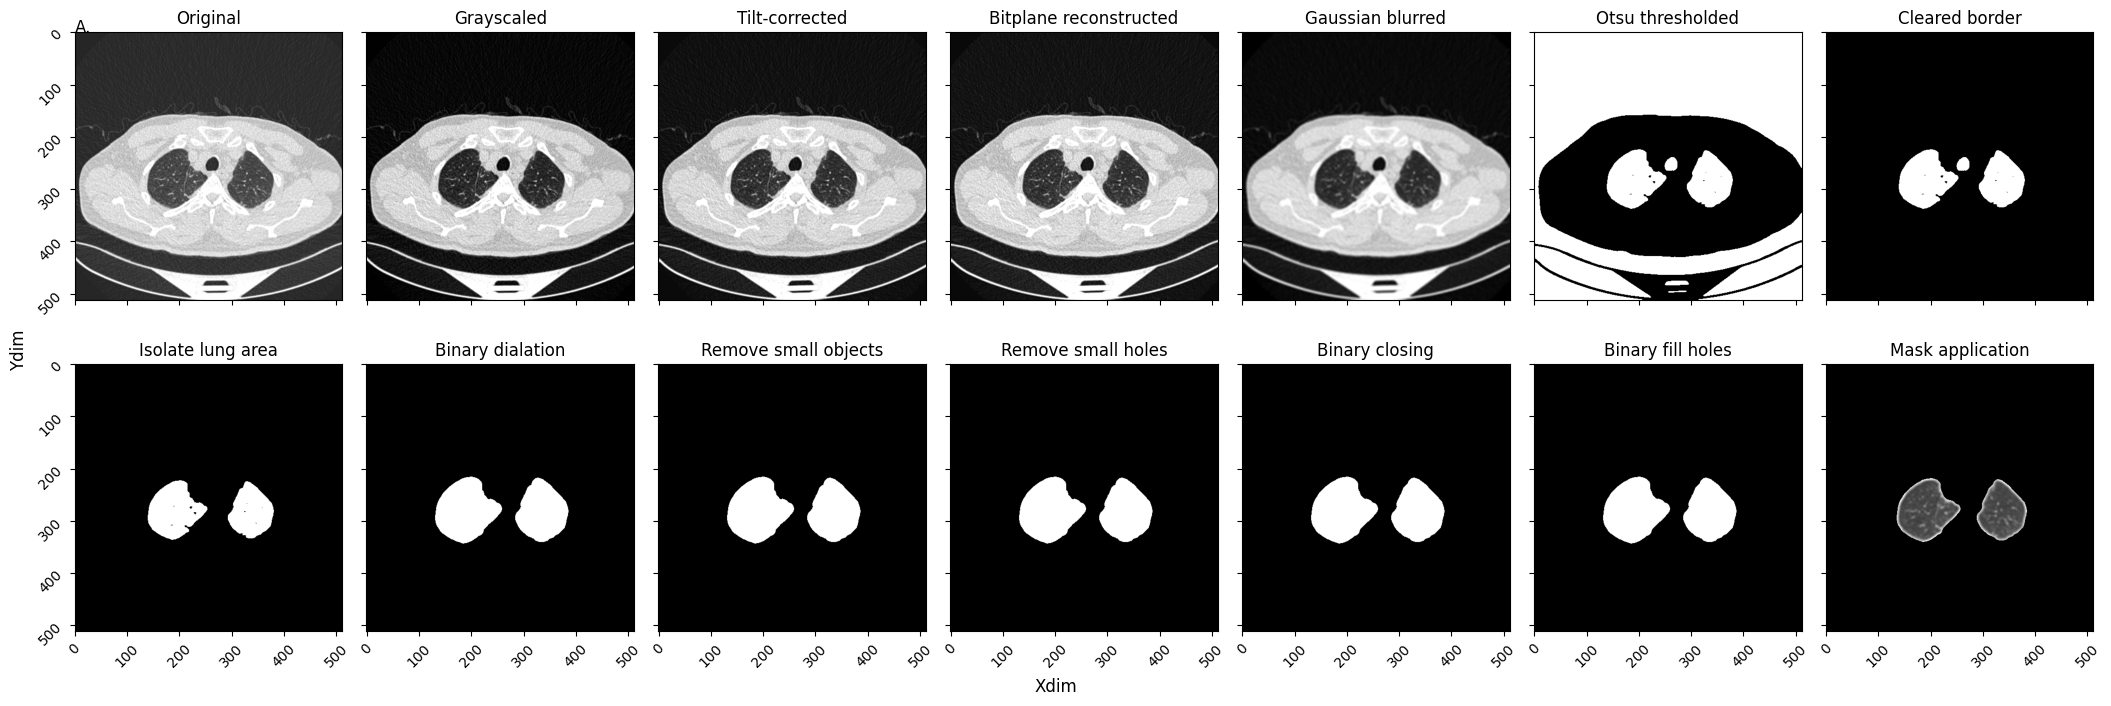

In [ ]:
def pipeline_test(image):

  camera =  cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  angle, corrected = correct_skew(camera)
  bit_planes = bit_plane_slice(corrected)
  bit_plane_reconstructed = reconstruct_image(bit_planes)
  gauss = cv.GaussianBlur(bit_plane_reconstructed, (5, 5), 5)
  thresh_val = filters.threshold_otsu(gauss)
  thresh = gauss<thresh_val



  selem = disk(3, dtype=bool)

  cleared = clear_border(thresh)

  height = cleared.shape[0]
  bed_cutoff = int(height * 0.85)
  cleared[bed_cutoff:, :] = False


  cleared1 = isolate_lung_area(cleared)
  cleared2 = binary_dilation(cleared1, footprint=disk(7))
  cleared3 = remove_small_objects(cleared2,min_size=650)
  cleared4 = remove_small_holes(cleared3,area_threshold=900)
  cleared5 = binary_closing(cleared4,disk(7))
  cleared6 = ndi.binary_fill_holes(cleared5)
  cleared7 = binary_erosion(cleared6, selem)
  cleared8 = binary_closing(cleared7,disk(12))

  result1 = gauss.copy()
  result1[cleared8 == 0] = 0
  result1[cleared8 != 0] = gauss[cleared8 != 0]


  plt.figure()
  fig, axs = plt.subplots(2, 7, figsize=(21, 7), layout='constrained',
                          sharex=True, sharey=True)
  plt.xticks(rotation=45)

  axs[0,0].imshow(image)
  axs[0,0].set_title('Original')
  axs[0,0].annotate('A.',(0,1),fontsize=12)

  axs[0,1].imshow(camera,cmap="gray")
  axs[0,1].set_title('Grayscaled')

  axs[0,2].imshow(corrected,cmap="gray")
  axs[0,2].set_title('Tilt-corrected')

  axs[0,3].imshow(bit_plane_reconstructed,cmap="gray")
  axs[0,3].set_title('Bitplane reconstructed')

  axs[0,4].imshow(gauss,cmap="gray")
  axs[0,4].set_title('Gaussian blurred')

  axs[0,5].imshow(thresh,cmap="gray")
  axs[0,5].set_title('Otsu thresholded')

  axs[0,6].imshow(cleared,cmap="gray")
  axs[0,6].set_title('Cleared border')

  axs[1,0].imshow(cleared1,cmap="gray")
  axs[1,0].set_title('Isolate lung area')

  axs[1,1].imshow(cleared2,cmap="gray")
  axs[1,1].set_title('Binary dialation')

  axs[1,2].imshow(cleared3,cmap="gray")
  axs[1,2].set_title('Remove small objects')

  axs[1,3].imshow(cleared4,cmap="gray")
  axs[1,3].set_title('Remove small holes')

  axs[1,4].imshow(cleared5,cmap="gray")
  axs[1,4].set_title('Binary closing')

  axs[1,5].imshow(cleared6,cmap="gray")
  axs[1,5].set_title('Binary fill holes')

  #axs[1,6].imshow(cleared7,cmap="gray")
  #axs[1,6].set_title('Binary erosion')

  axs[1,6].imshow(result1,cmap="gray")
  axs[1,6].set_title('Mask application')

  fig.supxlabel('Xdim')
  fig.supylabel('Ydim')
  for ax in fig.axes:
      plt.sca(ax)
      plt.xticks([0,100,200,300,400,500],rotation=45)
      plt.yticks(rotation=45)

problem_image = cv.imread(Lung_df_100["filepaths"][13])
#problem_image = cv.imread(Lung_df_200["filepaths"][13])
#problem_image = cv.imread(Lung_df_300["filepaths"][235])

pipeline_test(problem_image)

In [ ]:
def pipeline(image):
  camera =  cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  angle, corrected = correct_skew(camera)
  bit_planes = bit_plane_slice(corrected)
  bit_plane_reconstructed = reconstruct_image(bit_planes)
  gauss = cv.GaussianBlur(bit_plane_reconstructed, (5, 5), 5)
  thresh_val = filters.threshold_otsu(gauss)
  thresh = gauss<thresh_val



  cleared = clear_border(thresh)

  height = cleared.shape[0]
  bed_cutoff = int(height * 0.85)
  cleared[bed_cutoff:, :] = False

  cleared = isolate_lung_area(cleared)
  cleared = binary_dilation(cleared, footprint=disk(8))
  cleared = remove_small_objects(cleared,min_size=650)
  cleared = remove_small_holes(cleared,area_threshold=900)
  selem = disk(3, dtype=bool)
  cleared = binary_closing(cleared,disk(8))
  cleared = ndi.binary_fill_holes(cleared)
  cleared = binary_erosion(cleared, selem)

  cleared = binary_closing(cleared,disk(12))

  result1 = gauss.copy()
  result1[cleared == 0] = 0
  result1[cleared != 0] = gauss[cleared != 0]
  return result1

<ipython-input-194-bf69c9dca6a3>:115: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


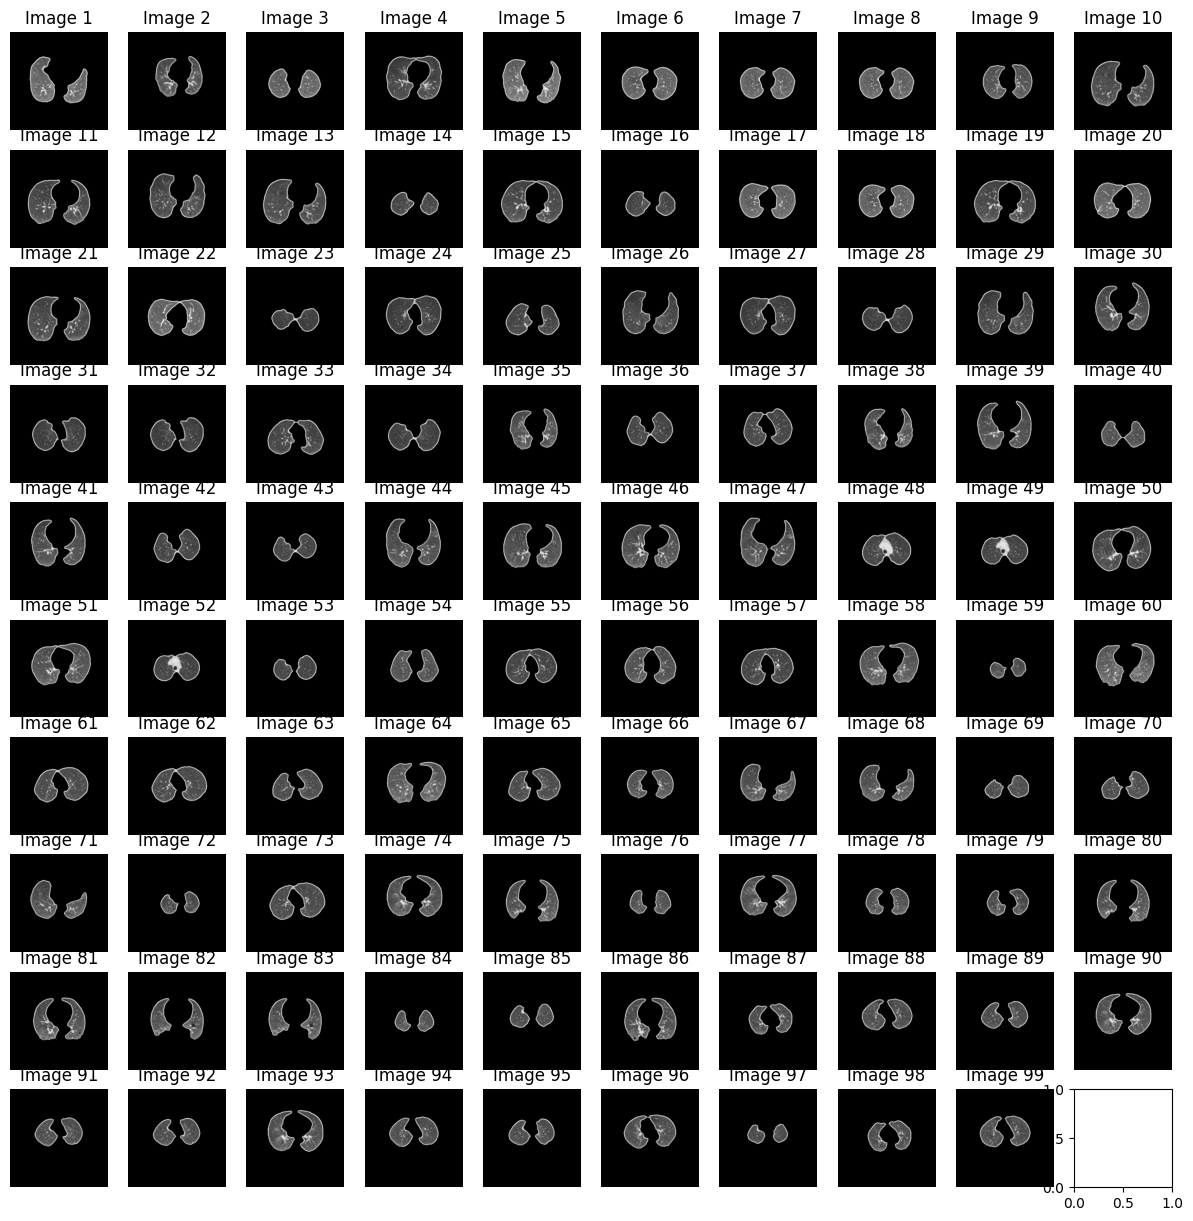

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
axs = axs.flatten()

for index, (ax, value) in enumerate(zip(axs, Lung_df_100["filepaths"])):
    image = cv.imread(value)
    processed_image = pipeline(image)
    ax.imshow(processed_image, cmap='gray')
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Image {index+1}')


<ipython-input-194-bf69c9dca6a3>:115: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


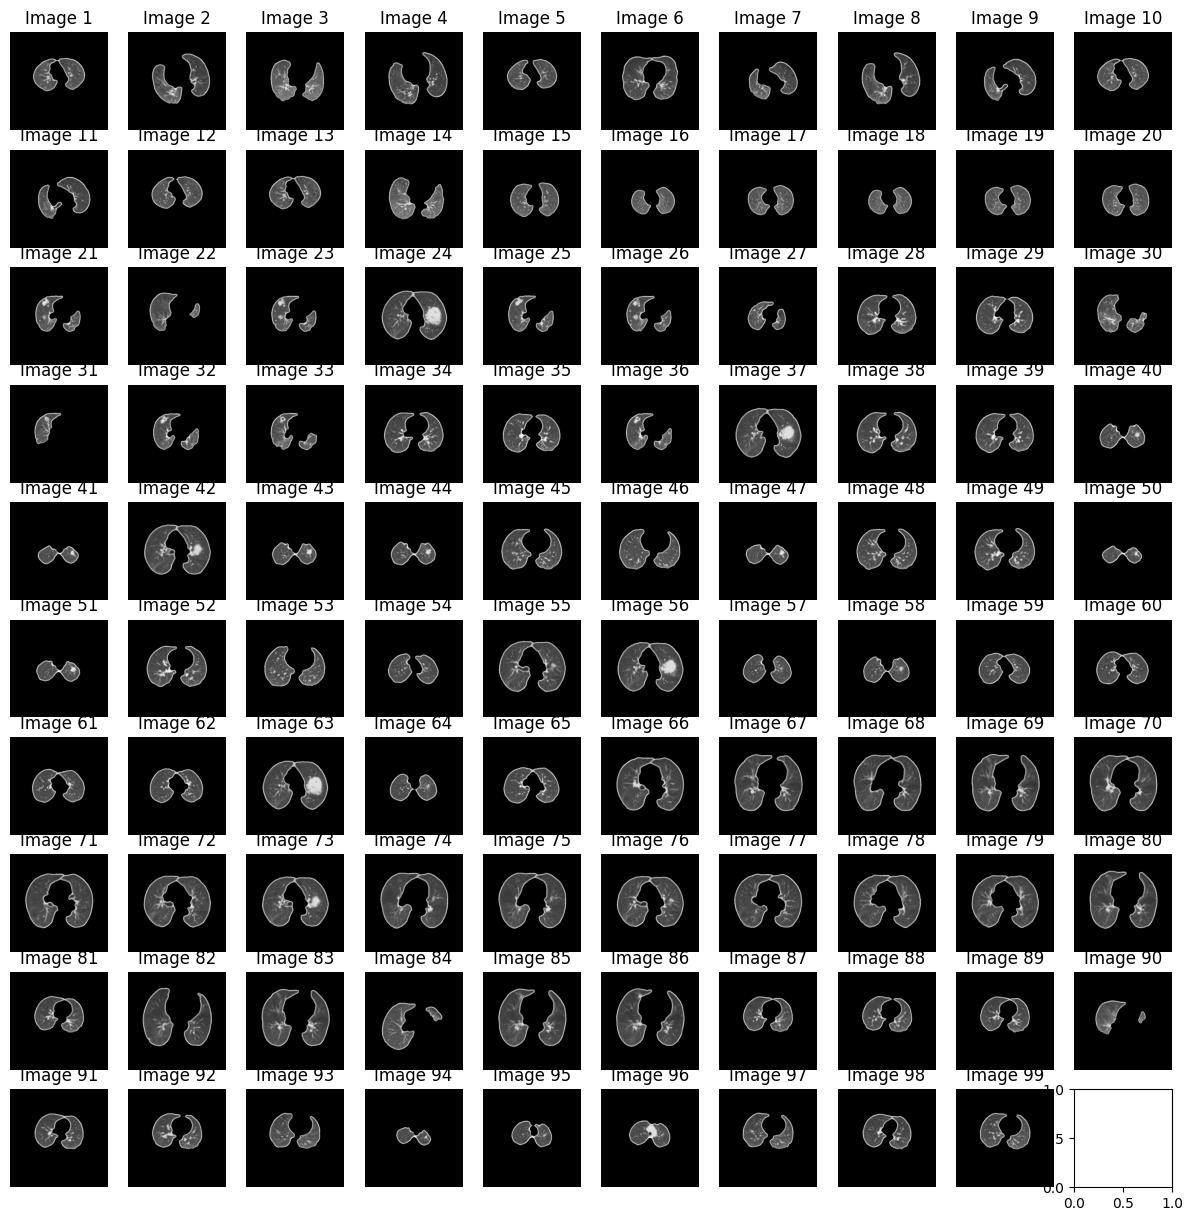

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
axs = axs.flatten()

for index, (ax, value) in enumerate(zip(axs, Lung_df_200["filepaths"])):
    image = cv.imread(value)
    processed_image = pipeline(image)
    ax.imshow(processed_image, cmap='gray')
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Image {index+1}')

<ipython-input-194-bf69c9dca6a3>:115: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


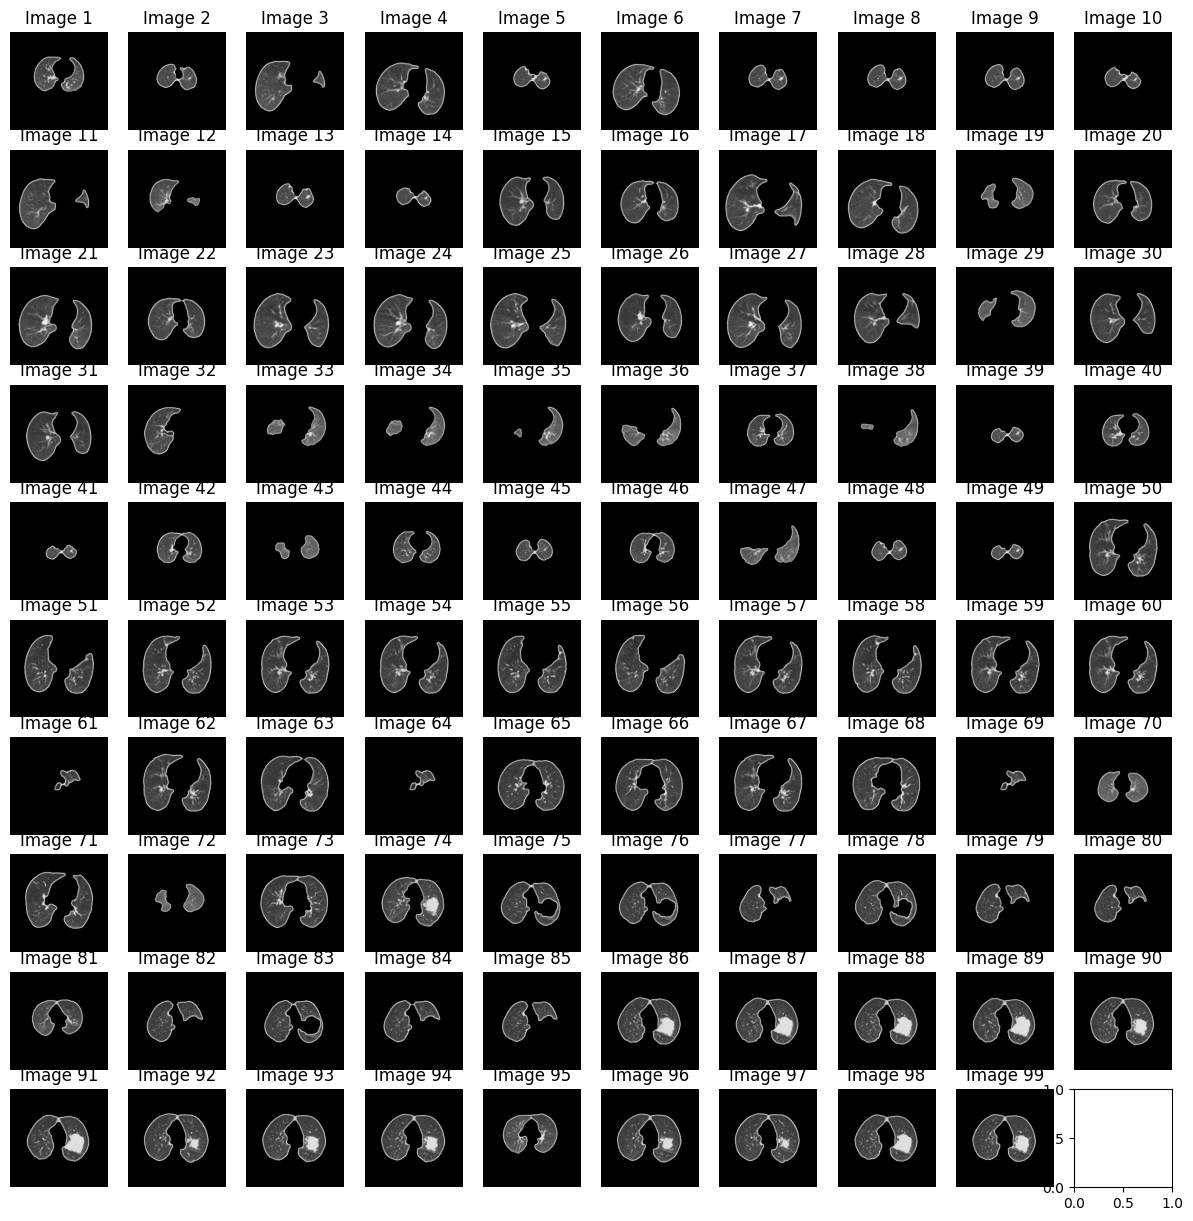

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
axs = axs.flatten()

for index, (ax, value) in enumerate(zip(axs, Lung_df_300["filepaths"])):
    image = cv.imread(value)
    processed_image = pipeline(image)
    ax.imshow(processed_image, cmap='gray')
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Image {index+1}')

## Lung Segmentation using U-Net Attempt
https://github.com/JoHof/lungmask

In [ ]:
pip install git+https://github.com/JoHof/lungmask.git@v0.2.19

  Cloning https://github.com/JoHof/lungmask.git (to revision v0.2.19) to /tmp/pip-req-build-gqekvzbr
  Running command git clone --filter=blob:none --quiet https://github.com/JoHof/lungmask.git /tmp/pip-req-build-gqekvzbr
  Running command git checkout -q b0d4ab86548e514eb2a4d85b384af973807afd39
  Resolved https://github.com/JoHof/lungmask.git to commit b0d4ab86548e514eb2a4d85b384af973807afd39
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


lungmask 2024-07-18 02:51:16 No GPU found, using CPU instead


1it [00:03,  3.97s/it]

lungmask 2024-07-18 02:51:20 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 5118.13it/s]


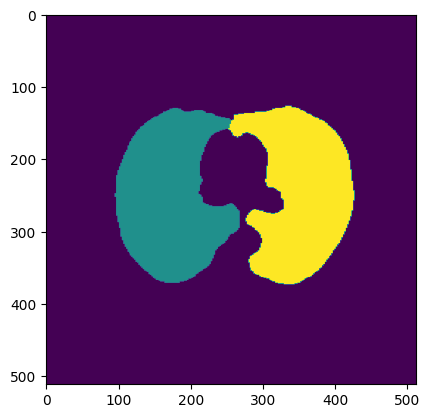

In [ ]:
from PIL import Image
import numpy as np
import SimpleITK as sitk
from lungmask import mask
import matplotlib.pyplot as plt

#Implementation with Dicom Image - need to replicate with .jpg
INPUT = './data/The IQ-OTHNCCD lung cancer dataset/Pre-segment/1-26.dcm'
input_image = sitk.ReadImage(INPUT)


segmentation = mask.apply(input_image) # default model is U-net(R231)
matplotlib.pyplot.imshow(segmentation[0])
matplotlib.pyplot.show()

In [ ]:
# Load the JPG image
INPUT_JPG = './data/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (86).jpg'
image = Image.open(INPUT_JPG)

# Convert the image to a numpy array
image_array = np.array(image)

# Convert the numpy array to a SimpleITK image
input_image1 = sitk.GetImageFromArray(image_array)


# **Set direction cosine matrix (assuming a standard orientation)**
image_array = sitk.GetArrayFromImage(input_image1).squeeze()

In [ ]:
image_array.size

786432

In [ ]:
image_array.shape

(512, 512, 3)

array([[[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       ...,

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]],

       [[38, 38, 38],
        [38, 38, 38],
        [38, 38, 38],
        ...,
        [38, 38, 38],
        [38, 38, 38],
        [38, 38, 38]]], dtype=uint8)
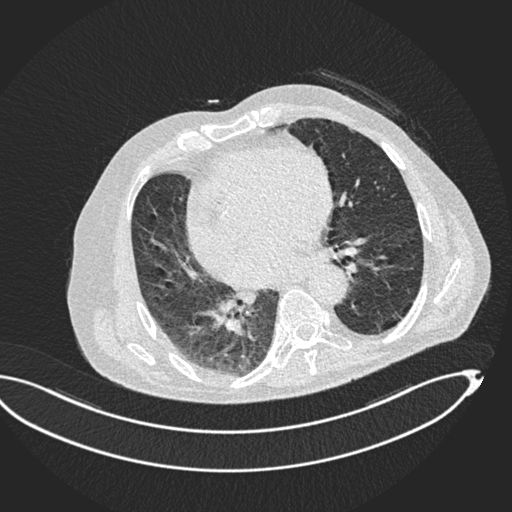

In [ ]:
image_array

In [ ]:
# Apply the lung segmentation mask using the default U-net (R231) model
segmentation = mask.apply_fused(image_array, noHU=True)

# Display the first slice of the segmentation result
plt.imshow(segmentation[0])
plt.title('Lung Segmentation')
plt.axis('off')
plt.show()

lungmask 2024-07-18 02:40:11 No GPU found, using CPU instead
lungmask 2024-07-18 02:40:12 Apply: LTRCLobes


IndexError: index 0 is out of bounds for axis 0 with size 0